In [62]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import wfdb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import neurokit2 as nk
from scipy.signal import resample, medfilt
import pywt
import pickle
import time
import os
import mne
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import neurokit2 as nk
from zoneinfo import ZoneInfo

In [63]:
def preprocessing_data(data):
    coeffs = pywt.wavedec(data, 'db4', level=5) #Wavelet decomposition, reduces noise, enhances key elements
    data = pywt.waverec(coeffs, 'db4')
    data = medfilt(data, kernel_size=5) #Reduces noise further
    data = nk.signal_resample(signal=data, sampling_rate=360, desired_sampling_rate=100)
    return data

In [64]:
def load_record(record_id, seq_len=1000, stride=1000):
    record_name = str(record_id)
    if not os.path.exists(f"mit_bih/{record_name}.dat"):
        wfdb.dl_database('mitdb', './', records=[record_name])
    record = wfdb.rdrecord('mit_bih/' + record_name)
    
    #Extract each channel
    signal_data = record.p_signal
    ch1 = preprocessing_data(signal_data[:, 0]).reshape(-1, 1)
    ch2 = preprocessing_data(signal_data[:, 1]).reshape(-1, 1)

    #Scale the signal
    scaler1 = MinMaxScaler(feature_range=(-0.5, 0.5))
    scaler2 = MinMaxScaler(feature_range=(-0.5, 0.5))
    ch1_scale = scaler1.fit_transform(ch1)
    ch2_scale = scaler2.fit_transform(ch2)

    
    # Create sequences using sliding window
    seq_ch1 = [ch1_scale[i:i+seq_len] for i in range(0, len(ch1_scale)-seq_len+1, stride)]
    seq_ch2 = [ch2_scale[i:i+seq_len] for i in range(0, len(ch2_scale)-seq_len+1, stride)]
    seq_ch1.extend(seq_ch2)
    return seq_ch1

def load_multiple_records(record_ranges, seq_len=1000, stride_len=100):
    all_data = []

    for start, end in tqdm(record_ranges):
        for record_id in range(start, end + 1):
            record_data = load_record(record_id, seq_len, stride_len)
            all_data.extend(record_data)
    # Save to pkl
    with open('database.pkl', 'wb') as f:
        pickle.dump(all_data, f)
    
    return all_data

In [65]:
def downsample(data, original_rate, target_rate):
    num_samples = int(len(data) * target_rate / original_rate)
    return resample(data, num_samples)

def calculate_l1(predictions, targets):
    l1_norm = torch.norm(predictions-targets, p=1)
    l1_sum = torch.sum(torch.abs(targets))
    accuracy = 100 * (1 - (l1_norm / l1_sum))
    return accuracy

def calculate_l2(predictions, targets):
    l2_norm = torch.norm(predictions - targets, p=2)
    l2_sum = torch.norm(targets, p=2)
    accuracy = 100 * (1 - (l2_norm / l2_sum))
    return accuracy

def calculate_MAPE(predictions, targets):
    mape = torch.mean(torch.abs((targets - predictions) / (targets)))
    return mape

In [66]:
def fixed_position_mask_peaks(rpeaks, seq, mask_length, num_peaks_to_mask):
    mask = np.zeros_like(seq, dtype=bool)  # Create a mask with the same length as seq, initially all False

    if len(rpeaks) > 0:  # If there are detected peaks
        # Randomly select 'num_peaks_to_mask' peaks from rpeaks
        selected_peaks = rpeaks[1:2*num_peaks_to_mask + 1: 2]

        for peak in selected_peaks:
            mask_half = mask_length // 2
            start = int(max(0, peak - mask_half))
            end = int(min(len(seq), peak + mask_half))
            mask[start:end] = True
    
    return mask

def fixed_position_mask_peaks_int(rpeaks, seq, mask_length, num_peaks_to_mask):
    mask = np.ones_like(seq, dtype=float)  # Create a mask with the same length as seq, initially all False

    if len(rpeaks) > 0:  # If there are detected peaks
        # Randomly select 'num_peaks_to_mask' peaks from rpeaks
        selected_peaks = rpeaks[1:2*num_peaks_to_mask + 1: 2]

        for peak in selected_peaks:
            mask_half = mask_length // 2
            start = int(max(0, peak - mask_half))
            end = int(min(len(seq), peak + mask_half))
            mask[start:end] = 0
    
    return mask

In [67]:
import torch
from torch.utils.data import Dataset
import numpy as np
import neurokit2 as nk

class ECGDataset(Dataset):
    def __init__(self, data, seq_len=1000, mask_length=30, target_rate=100, num_peaks_to_mask=1):
        """
        Args:
            data (np.array): Full ECG signal data.
            seq_len (int): Length of each sequence before downsampling.
            mask_length (int): Length of masking window around the first R-peak.
            target_rate (int): Target sampling rate after downsampling.
            augment (bool): Whether to apply data augmentation.
        """
        self.data = data
        self.seq_len = seq_len
        self.mask_length = mask_length
        self.target_rate = target_rate
        self.num_peaks_to_mask = num_peaks_to_mask

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx].flatten()
        # Detect R-peaks
        rpeaks = nk.ecg_findpeaks(seq, sampling_rate=self.target_rate)['ECG_R_Peaks']

        # Create masking
        mask = fixed_position_mask_peaks(rpeaks, seq, self.mask_length, self.num_peaks_to_mask)
        mask_int = fixed_position_mask_peaks_int(rpeaks, seq, self.mask_length, self.num_peaks_to_mask)

        masked_seq = seq.copy()
        masked_seq[mask] = 0  # Apply masking

        return (
            torch.tensor(masked_seq, dtype=torch.float32),
            torch.tensor(seq, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.bool),
            torch.tensor(mask_int, dtype=torch.float32)
        )


In [68]:
class Encoder1D_Mask(nn.Module):
    def __init__(self, embed_dim=32, hidden_dim=64, lstm_hidden_dim=128):
        super(Encoder1D_Mask, self).__init__()
        self.conv1 = nn.Conv1d(1, embed_dim, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(embed_dim, embed_dim * 2, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(embed_dim * 2, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.bilstm = nn.LSTM(hidden_dim, lstm_hidden_dim, bidirectional=True, batch_first=True)

    def forward(self, x, mask):
        # Input: (B, L) → (B, 1, L)
        x = x.unsqueeze(1)

        # Downsample the mask along with the input
        mask1 = F.max_pool1d(mask, kernel_size=2, stride=2)   # (B, 1, L/2)
        mask2 = F.max_pool1d(mask1, kernel_size=2, stride=2)  # (B, 1, L/4)
        mask3 = F.max_pool1d(mask2, kernel_size=1, stride=1)  # (B, 1, L/4)

        x = F.leaky_relu(self.conv1(x), negative_slope=0.01)
        x = self.pool1(x)

        x = F.leaky_relu(self.conv2(x), negative_slope=0.01)
        x = self.pool2(x)

        x = F.leaky_relu(self.conv3(x), negative_slope=0.01)

        # Prepare for LSTM
        x = x.permute(0, 2, 1)  # (B, L, C)
        x, _ = self.bilstm(x)
        x = x.permute(0, 2, 1)  # (B, C, L)

        return x


class Decoder1D(nn.Module):
    def __init__(self, embed_dim=32, hidden_dim=64, lstm_hidden_dim=128):
        super(Decoder1D, self).__init__()
        self.deconv1 = nn.Conv1d(lstm_hidden_dim * 2, embed_dim * 2, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.Conv1d(embed_dim * 2, embed_dim, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.Conv1d(embed_dim, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.deconv1(x), negative_slope=0.01)
        x = F.interpolate(x, scale_factor=2, mode='linear', align_corners=True)

        x = F.leaky_relu(self.deconv2(x), negative_slope=0.01)
        x = F.interpolate(x, scale_factor=2, mode='linear', align_corners=True)

        x = self.deconv3(x)  # (B, 1, L)
        return x.squeeze(1)  # (B, L)


class MAE1D_Mask(nn.Module):
    def __init__(self, embed_dim=32, hidden_dim=64, lstm_hidden_dim=128):
        super(MAE1D_Mask, self).__init__()
        self.encoder = Encoder1D_Mask(embed_dim, hidden_dim, lstm_hidden_dim)
        self.decoder = Decoder1D(embed_dim, hidden_dim, lstm_hidden_dim)

    def forward(self, x, mask):
        x = self.encoder(x, mask)
        x = self.decoder(x)
        return x

In [69]:
# Data preparation
def prepare_data(data, seq_len, num_rpeaks, mask_len, batch_size=128):
    dataset = ECGDataset(data, seq_len, mask_length = mask_len, num_peaks_to_mask = num_rpeaks)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [70]:
class Trainer:
    def __init__(self, model, criterion, optimizer, seq_len=5000, num_rpeak=1, log_dir=None, masking_length = 30,scale = 'minmax_0_5',test_case = True):
        self.seq_len = seq_len
        self.num_rpeak = num_rpeak
        self.mask_len = masking_length
        self.scale = scale
        self.device = ( "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.log_dir = log_dir
        self.test_case = test_case
        self.cur_time = datetime.now(ZoneInfo("Australia/Sydney")).strftime("%H%M_%d%m%Y")
        if self.log_dir is None:
            self.log_dir = f'runs/seq{seq_len}_rpeak{num_rpeak}_{self.cur_time}'
        if self.test_case == False:
            self.writer = SummaryWriter(log_dir=self.log_dir)

    def run(self, train_loader, val_loader, test_loader, epochs=100, patience = 10):
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            for masked_seq, original_seq, mask, mask_int in train_loader:
                masked_seq, original_seq, mask,mask_int = masked_seq.to(self.device), original_seq.to(self.device), mask.to(self.device), mask_int.to(self.device)

                self.optimizer.zero_grad()
                reconstructed = self.model(masked_seq, mask_int)

                loss_global = self.criterion(reconstructed, original_seq)
                loss_masked = self.criterion(reconstructed[mask], original_seq[mask])
                loss = 0.9 * loss_masked + 0.1 * loss_global

                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)

            avg_val_loss, avg_l1, avg_l2, avg_MAPE = self.evaluate(epoch=epoch, data_loader = val_loader)
            self.val_losses.append(avg_val_loss)

            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
                  f"L1 Accuracy: {avg_l1:.2f}, L2 Accuracy: {avg_l2:.2f}, MAPE Accuracy: {avg_MAPE:.2f}")
            if self.test_case == False:
                self.writer.add_scalar("Loss/Train", avg_train_loss, epoch)
                self.writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
                self.writer.add_scalar("Accuracy/L1", avg_l1, epoch)
                self.writer.add_scalar("Accuracy/L2", avg_l2, epoch)
                self.writer.add_scalar("Accuracy/MAPE", avg_MAPE, epoch)

            if epoch % 10 == 10:
                print(f"{self.log_dir}/model_{self.seq_len}_{self.num_rpeak}_{self.cur_time}.pth")
                if self.test_case == False:
                    print("Saving the best model checkpoint...")
                    torch.save(self.model.state_dict(), f"{self.log_dir}/model_{self.seq_len}_{self.num_rpeak}_{self.cur_time}.pth")

        self.writer.close()
        if test_loader is None:
            self.final_evaluation(val_loader)
        else: 
            self.final_evaluation(test_loader)
            
    def evaluate(self, data_loader, epoch= None):
        self.model.eval()
        val_loss = 0.0
        l1_accuracy = 0.0
        l2_accuracy = 0.0
        MAPE_accuracy = 0.0

        with torch.no_grad():
            for masked_seq, original_seq, mask, mask_int in data_loader:
                masked_seq, original_seq, mask, mask_int = masked_seq.to(self.device), original_seq.to(self.device), mask.to(self.device), mask_int.to(self.device)
                reconstructed = self.model(masked_seq, mask_int)
                masked_reconstructed = reconstructed[mask]
                masked_original = original_seq[mask]
                loss = self.criterion(masked_reconstructed, masked_original)
                val_loss += loss.item()
                l1_accuracy += calculate_l1(masked_reconstructed, masked_original)
                l2_accuracy += calculate_l2(masked_reconstructed, masked_original)
                MAPE_accuracy += calculate_MAPE(masked_reconstructed, masked_original)

        avg_val_loss = val_loss / len(data_loader)
        avg_l1 = l1_accuracy / len(data_loader)
        avg_l2 = l2_accuracy / len(data_loader)
        avg_MAPE = MAPE_accuracy / len(data_loader)

        if epoch is None:
            print(f"\nValidation Loss: {avg_val_loss:.4f}")
            print(f"L1 Accuracy: {avg_l1:.4f}")
            print(f"L2 Accuracy: {avg_l2:.4f}")
            print(f"MAPE Accuracy: {avg_MAPE:.2f}%")
        return avg_val_loss, avg_l1, avg_l2, avg_MAPE
        
    def plot_predictions_with_residuals(self, model, data_loader, sample_len = None, num_samples=2 ):
        self.model.eval()
        all_actual, all_predicted, all_masks = [], [], []
        if sample_len is None:
            sample_len = self.seq_len
        
        with torch.no_grad():
            for masked_seq, original_seq, mask, mask_int in data_loader:
                masked_seq, original_seq, mask_int = masked_seq.to(self.device), original_seq.to(self.device), mask_int.to(self.device)
                reconstructed = model(masked_seq, mask_int)
                all_actual.extend(original_seq.cpu().numpy())  # original (unmasked) ECG
                all_predicted.extend(reconstructed.cpu().numpy())  # predictions
                all_masks.extend(mask.cpu().numpy()) # Masked regions
     
                break  # Take only one batch for plotting
        
        # Flatten the lists for metric calculation
        all_actual_flat = np.concatenate(all_actual)
        all_predicted_flat = np.concatenate(all_predicted)
        
        # Calculate metrics
        mse = mean_squared_error(all_actual_flat, all_predicted_flat)
        mae = mean_absolute_error(all_actual_flat, all_predicted_flat)
        r2 = r2_score(all_actual_flat, all_predicted_flat)
    
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R²): {r2:.4f}")
        
        # Visualize predictions vs. actual data with residuals
        plt.figure(figsize=(15, num_samples * 5))
        for i in range(min(num_samples, len(all_actual))):
            original = all_actual[i]
            predicted = all_predicted[i]
            mask = all_masks[i]
    
            # Plot predictions vs actual data
            plt.subplot(num_samples, 2, i * 2 + 1)
            plt.plot(original[:sample_len], label="Original", color="blue", alpha=0.7)
            plt.plot(predicted[:sample_len], label="Predicted", color="orange", alpha=0.7)
    
            # Highlight masked regions
            masked_indices = np.where(mask)[0]
            plt.scatter(masked_indices, original[masked_indices], color="red", label="Masked Regions", alpha=0.7)
    
            plt.title(f"Sample {i + 1} - Predictions")
            plt.legend()
    
            # Compute and plot residuals
            residuals = np.array(original) - np.array(predicted)
            plt.subplot(num_samples, 2, i * 2 + 2)
            plt.plot(residuals[:sample_len], label="Residuals", color="green")
            plt.axhline(0, color="black", linestyle="--")
            plt.title(f"Sample {i + 1} - Residuals")
            plt.legend()
    
        plt.tight_layout()
        plt.show()

    def plot_loss_curves(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss", marker='o')
        plt.plot(self.val_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curves")
        plt.legend()
        plt.grid()
        plt.show()
        
    def final_evaluation(self, data_loader):
        avg_val_loss, avg_l1, avg_l2, avg_MAPE = self.evaluate(data_loader, epoch= None)
        with open('runs/Model_Running.csv', 'a') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow([f'model_{self.seq_len}_{self.num_rpeak}_{self.cur_time}.pth', avg_l1.cpu().numpy(), avg_l2.cpu().numpy(), avg_MAPE.cpu().numpy(), self.seq_len, self.num_rpeak, self.mask_len, self.scale])
            f_object.close()  
        self.plot_predictions_with_residuals(self.model, data_loader, sample_len = 1000)
        self.plot_loss_curves()

In [71]:
def plot_some_sample(data_loader, device, num_samples=5):
    all_actual, all_masks = [], []
    with torch.no_grad():
        for masked_seq, original_seq, mask in data_loader:
            all_actual.extend(original_seq)  # original (unmasked) ECG
            all_masks.extend(mask) # Masked regions
            break
            
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(min(num_samples, len(all_actual))):
        original = all_actual[i]
        mask = all_masks[i]

        # Plot predictions vs actual data
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.plot(original, label="Original", color="blue", alpha=0.7)

        # Highlight masked regions
        masked_indices = np.where(mask)[0]
        plt.scatter(masked_indices, original[masked_indices], color="red", label="Masked Regions", alpha=0.7)

        plt.title(f"Sample {i + 1} - Predictions")
        plt.legend()    

def plot_ecg_sample_no_mask(data, num_samples=2):
    # Visualize predictions vs. actual data with residuals
    fig, ax = plt.subplots(1, num_samples, figsize = (16,9))
    ax = ax.flatten()
    for i in range(0, num_samples):
        # Plot predictions vs actual data
        ax[i].plot(data[i], label="Original", color="blue", alpha=0.7)
    plt.tight_layout()
    plt.show()

Working with data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Training the model with 4 R peaks
Preparing the data
Training the model
Epoch 0, Train Loss: 0.0056, Val Loss: 0.0041, L1 Accuracy: 60.07, L2 Accuracy: 47.51, MAPE Accuracy: 3.30
Epoch 1, Train Loss: 0.0032, Val Loss: 0.0027, L1 Accuracy: 67.98, L2 Accuracy: 57.58, MAPE Accuracy: 3.22
Epoch 2, Train Loss: 0.0022, Val Loss: 0.0022, L1 Accuracy: 70.37, L2 Accuracy: 62.10, MAPE Accuracy: 2.45
Epoch 3, Train Loss: 0.0017, Val Loss: 0.0016, L1 Accuracy: 75.85, L2 Accuracy: 67.31, MAPE Accuracy: 1.87
Epoch 4, Train Loss: 0.0014, Val Loss: 0.0014, L1 Accuracy: 77.67, L2 Accuracy: 69.49, MAPE Accuracy: 2.01
Epoch 5, Train Loss: 0.0013, Val Loss: 0.0013, L1 Accuracy: 78.70, L2 Accuracy: 70.97, MAPE Accuracy: 1.80
Epoch 6, Train Loss: 0.0011, Val Loss: 0.0012, L1 Accuracy: 79.35, L2 Accuracy: 71.96, MAPE Accuracy: 2.00
Epoch 7, Train Loss: 0.0011, Val Loss: 0.0011, L1 Accuracy: 80.31, L2 Accuracy: 72.90, MAPE Accuracy: 1.82
Epoch 8, Train Loss: 0.0010, Val Loss: 0.0011, L1 Accuracy: 80.77, L2 Ac

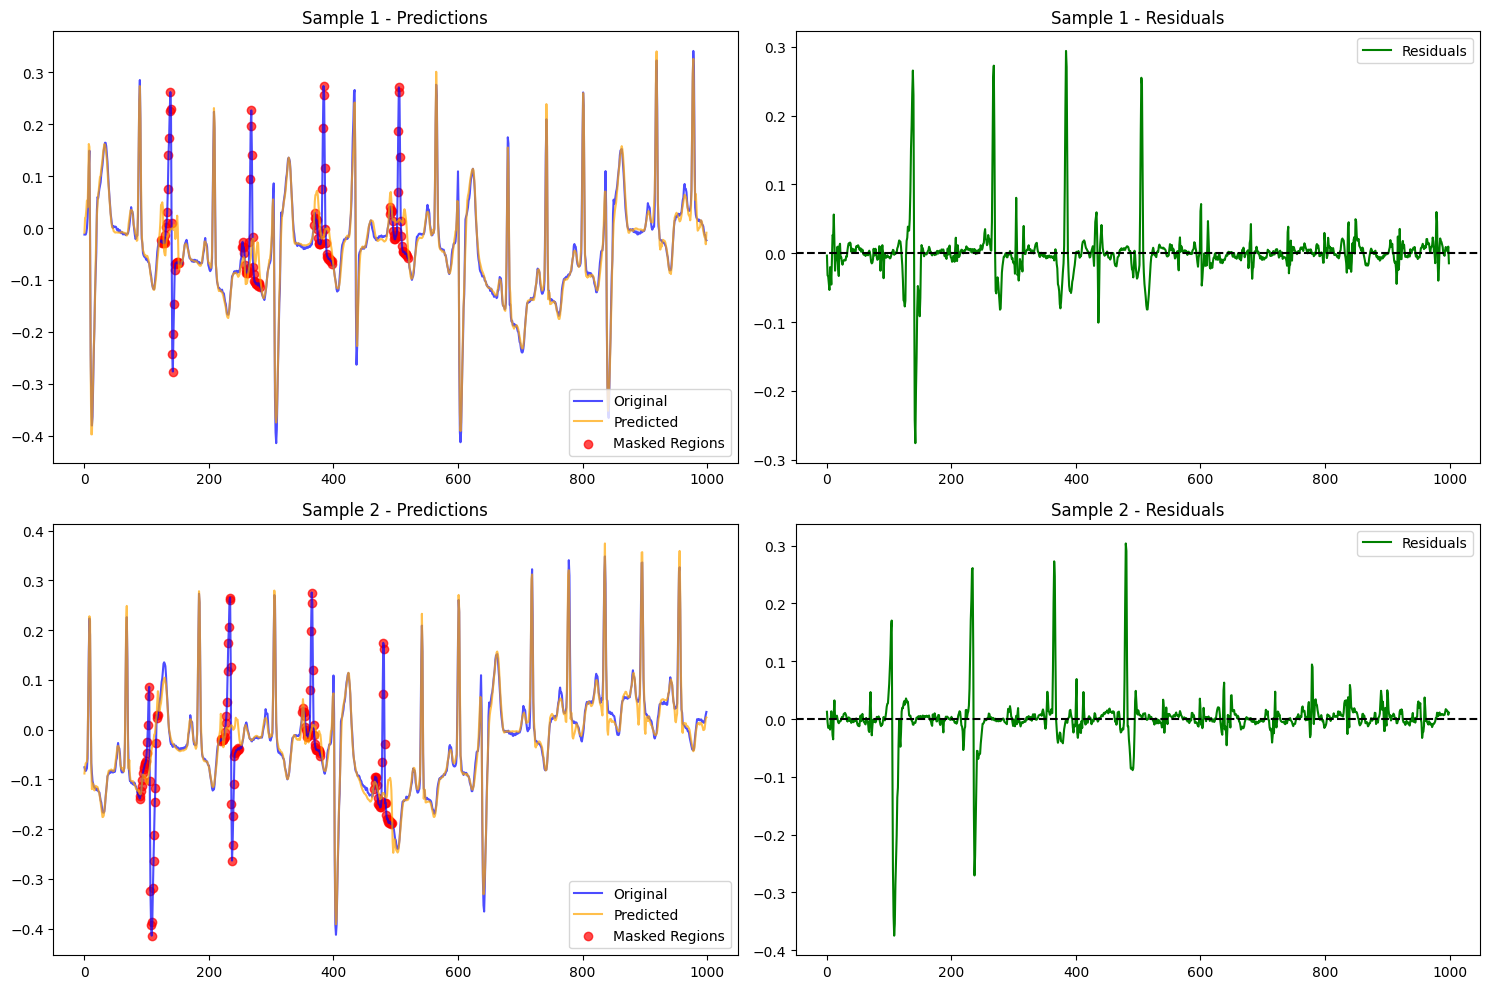

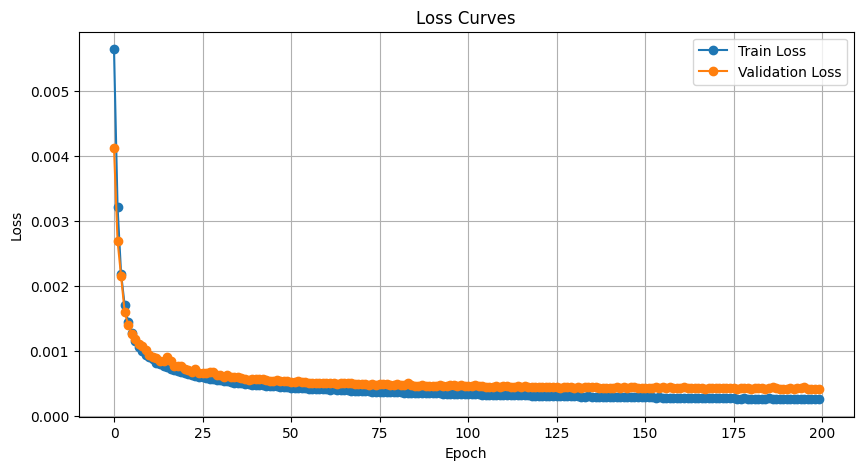

Training the model with 5 R peaks
Preparing the data
Training the model
Epoch 0, Train Loss: 0.0055, Val Loss: 0.0041, L1 Accuracy: 59.17, L2 Accuracy: 48.41, MAPE Accuracy: 3.17
Epoch 1, Train Loss: 0.0031, Val Loss: 0.0026, L1 Accuracy: 69.26, L2 Accuracy: 58.97, MAPE Accuracy: 3.08
Epoch 2, Train Loss: 0.0021, Val Loss: 0.0018, L1 Accuracy: 74.25, L2 Accuracy: 65.57, MAPE Accuracy: 2.59
Epoch 3, Train Loss: 0.0016, Val Loss: 0.0015, L1 Accuracy: 76.27, L2 Accuracy: 68.33, MAPE Accuracy: 2.21
Epoch 4, Train Loss: 0.0014, Val Loss: 0.0014, L1 Accuracy: 76.76, L2 Accuracy: 69.77, MAPE Accuracy: 2.04
Epoch 5, Train Loss: 0.0012, Val Loss: 0.0012, L1 Accuracy: 79.66, L2 Accuracy: 71.83, MAPE Accuracy: 2.06
Epoch 6, Train Loss: 0.0011, Val Loss: 0.0012, L1 Accuracy: 79.99, L2 Accuracy: 72.46, MAPE Accuracy: 1.95
Epoch 7, Train Loss: 0.0011, Val Loss: 0.0011, L1 Accuracy: 80.04, L2 Accuracy: 72.92, MAPE Accuracy: 1.86
Epoch 8, Train Loss: 0.0010, Val Loss: 0.0010, L1 Accuracy: 81.37, L2 Ac

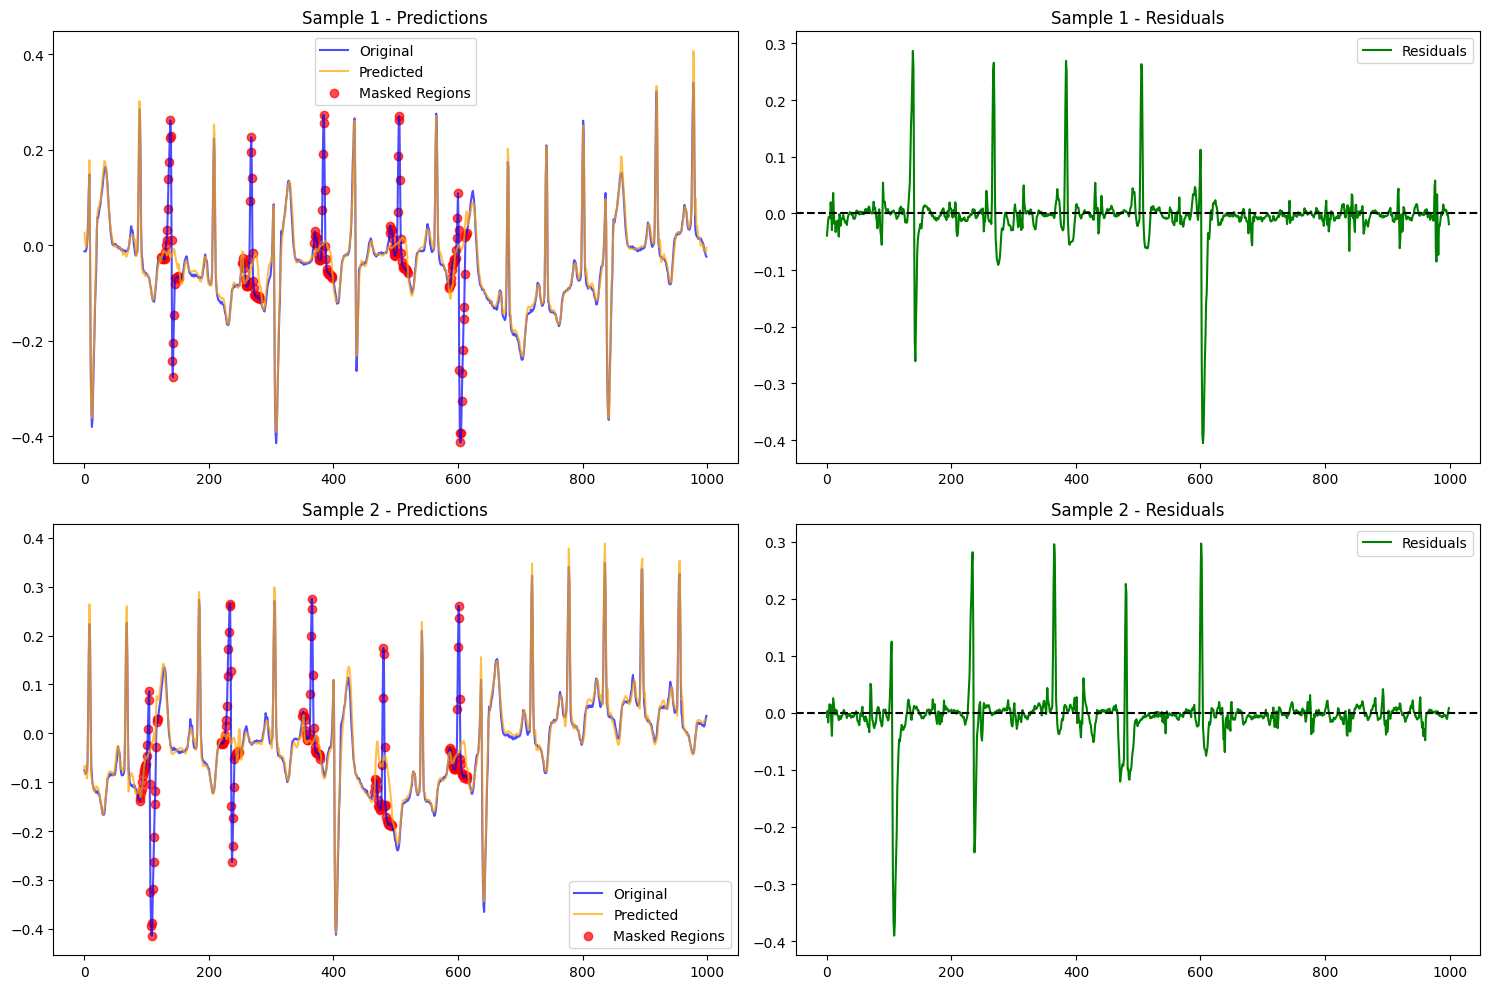

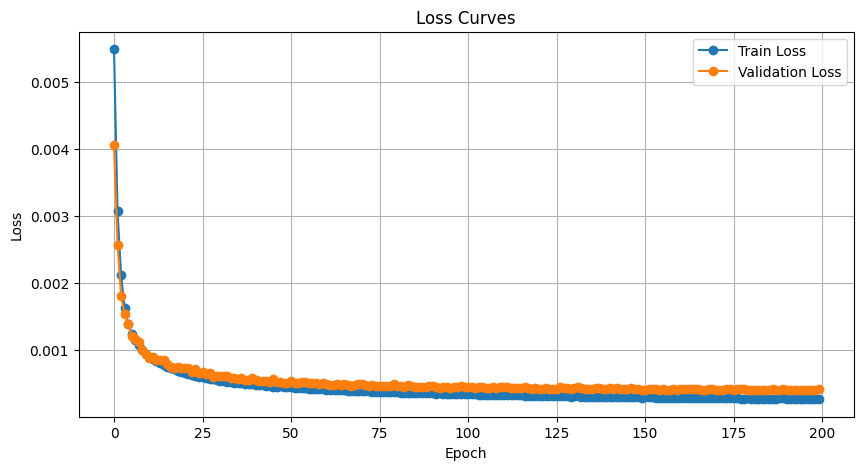

Training the model with 6 R peaks
Preparing the data
Training the model
Epoch 0, Train Loss: 0.0061, Val Loss: 0.0041, L1 Accuracy: 61.60, L2 Accuracy: 48.05, MAPE Accuracy: 4.98
Epoch 1, Train Loss: 0.0030, Val Loss: 0.0024, L1 Accuracy: 70.30, L2 Accuracy: 60.61, MAPE Accuracy: 3.48
Epoch 2, Train Loss: 0.0020, Val Loss: 0.0018, L1 Accuracy: 73.85, L2 Accuracy: 65.52, MAPE Accuracy: 3.18
Epoch 3, Train Loss: 0.0016, Val Loss: 0.0016, L1 Accuracy: 76.71, L2 Accuracy: 68.05, MAPE Accuracy: 2.22
Epoch 4, Train Loss: 0.0014, Val Loss: 0.0014, L1 Accuracy: 77.94, L2 Accuracy: 69.54, MAPE Accuracy: 2.44
Epoch 5, Train Loss: 0.0013, Val Loss: 0.0013, L1 Accuracy: 77.79, L2 Accuracy: 70.51, MAPE Accuracy: 2.10
Epoch 6, Train Loss: 0.0012, Val Loss: 0.0012, L1 Accuracy: 79.83, L2 Accuracy: 72.50, MAPE Accuracy: 2.25
Epoch 7, Train Loss: 0.0011, Val Loss: 0.0011, L1 Accuracy: 79.88, L2 Accuracy: 72.75, MAPE Accuracy: 1.83
Epoch 8, Train Loss: 0.0010, Val Loss: 0.0010, L1 Accuracy: 81.23, L2 Ac

KeyboardInterrupt: 

In [72]:
record_ranges = [(100,109),(111, 119),(121,124),(200,203),(205,205),(207,210),(212,215),(217,217),(219,223),(228,228),(230,232)]
print("Working with data")
seq_len = 1000
stride = 200
mask_length = 60
data = np.array(load_multiple_records(record_ranges, seq_len, stride))
test_data = load_multiple_records([(233,234)], seq_len, stride)

for num in [4, 5,6]: 
    print("="*20)
    print(f"Training the model with {num} R peaks")
    print("="*20)
    
    print("Preparing the data")
    train_loader, val_loader = prepare_data(data,num_rpeaks = num, seq_len=seq_len, mask_len = mask_length)
    test_dataset = ECGDataset(test_data, seq_len, num_peaks_to_mask = num)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    print("Training the model")
    criterion = nn.MSELoss()
    mae_model = MAE1D_Mask()
    optimizer = optim.Adam(mae_model.parameters(), lr=0.001)    

    model_trainer = Trainer(model = mae_model, 
                            criterion = criterion, optimizer = optimizer,  
                            seq_len=seq_len, masking_length = mask_length, num_rpeak=num, 
                            scale = 'Minmax_05',
                            test_case = False)
    model_trainer.run(train_loader, val_loader, test_loader, epochs = 200)

# Fine- truning

In [22]:
from torch.utils.data import DataLoader, TensorDataset
from wesad_processing import *

def load_wesad_dataset(root_dir, test_subject):
    folder_ls = os.listdir(root_dir)
    for i in folder_ls:
        if i == ".ipynb_checkpoints" or i == '.DS_Store':
            print(f"Removing {i}")
            folder_ls.remove(i)
    
    valid_ls = [test_subject]    
    # Create the train list by excluding test_ls
    train_ls = [subject for subject in folder_ls if subject not in valid_ls]
    print(train_ls)
    print("==========Loading Training set============")
    X_train, y_train = load_process_extract_ls(root_dir, train_ls,700, 5,5,True)
    print("==========Loading Testing set============")
    X_test, y_test = load_process_extract_ls(root_dir,valid_ls,700, 5, 5,False)
    return X_train, X_test, y_train, y_test
    
class ECGClassificationDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # shape: [N, L]
        self.Y = Y  # shape: [N]
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        seq = self.X[idx].flatten()
        return torch.tensor(seq, dtype=torch.float32).unsqueeze(0), torch.tensor(self.Y[idx], dtype=torch.long)

In [ ]:
X_train, X_test, y_train, y_test = load_wesad_dataset('/home/van/NamQuang/ECG_Research/WESAD_LOSO', 'S14')
train_dataset = ECGClassificationDataset(X_train, y_train)
test_dataset = ECGClassificationDataset(X_test, y_test)

In [6]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader_wesad = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader_wesad = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader_wesad = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [16]:
import torch.nn.functional as F


class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, hidden_dim = 64, num_classes=2):
        super(DownstreamClassifier, self).__init__()
        self.encoder = encoder
        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Classifier head after GAP
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),  # hidden_dim = last conv channels output
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, mask= None):
        mask = torch.ones_like(x, dtype = torch.float32)
        x = x.squeeze(1)
        mask = mask.squeeze(1)
        z = self.encoder(x, mask)  # shape: (B, C=hidden_dim, L)
        
        # Global Average Pooling over the sequence dimension (L)
        z = F.adaptive_avg_pool1d(z, 1)  # shape: (B, C, 1)
        z = z.squeeze(-1)                 # shape: (B, C)
        logits = self.classifier(z)
        return logits

In [17]:
def evaluate(model, dataloader, criterion, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
    # --- Validation ---
    model.eval()
    
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for x_val, y_val in dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(y_val.cpu().numpy())
    
    prec_temp = precision_score(all_val_labels, all_val_preds)
    rec_temp = recall_score(all_val_labels, all_val_preds)
    f1_temp = f1_score(all_val_labels, all_val_preds,average='macro')
    acc_temp = accuracy_score(all_val_labels, all_val_preds)
    
    return prec_temp, rec_temp, f1_temp, acc_temp


In [18]:
def train_evaluate_downstream_classifier(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=60,
    device = 'cuda'
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
    model.to(device)
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(y.cpu().numpy())

        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(y_val.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_f1_macro = f1_score(all_val_labels, all_val_preds, average='macro')
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}: "
              f"Train Loss = {total_loss/len(train_loader):.4f}, "
              f"Train Acc = {train_accuracy:.4f}, "
              f"Train F1 = {train_f1_macro:.4f} | "
              f"Val Loss = {avg_val_loss:.4f}, "
              f"Val Acc = {val_accuracy:.4f}, "
              f"Val F1 = {val_f1_macro:.4f}")
        
    prec, rec, f1, acc = evaluate(model, test_loader, criterion, device)
    return prec, rec, f1, acc

In [23]:
def loso_training(root_dir, sample_rate, test_size,stride, filename, load_file):
    #Evaluation metrics
    prec = []
    rec = []
    acc =[]
    f1 = []
    save_file = filename 
    folder_ls = os.listdir(root_dir)
    for i in folder_ls:
        if i == ".ipynb_checkpoints" or i == '.DS_Store':
            print(f"Removing {i}")
            folder_ls.remove(i)
    #folder_ls.remove(".ipynb_checkpoints")
    with open(save_file, 'a') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow([])
        writer_object.writerow(["=================================================================================="])
        writer_object.writerow(['Adadelta: 0.1', 'notch, 0.5-40, emg_10', 'QRS_200_220', 'StandardScale Global', 'Reverse', '256-02-128-02', 'leaky-0.01'])
        writer_object.writerow(["=================================================================================="])
        f_object.close()
    start_index = np.arange(0,len(folder_ls) - test_size + 1, stride)
    print(start_index)
    for i, start in enumerate(start_index):
        print("************************************")
        print(f"*The loop {i}                 *")
        print("************************************")
        if load_file:
            valid_ls = folder_ls[start:start + test_size]
            train_ls = [subject for subject in folder_ls if subject not in valid_ls]
    
            # ========== Loading Training Set ==========
            print("========== Loading Training Set ===========")
            X_train_list = []
            y_train_list = []
            for s in train_ls:
                train_path = os.path.join(root_dir, s)
                temp_df = pd.read_pickle(train_path)
    
                x = temp_df["X_train"]
                y = temp_df["y_train"]
    
                if x.ndim == 2:
                    x = x[..., np.newaxis]
    
                X_train_list.append(x)
                y_train_list.append(y)
    
            X_train = np.concatenate(X_train_list, axis=0)
            y_train = np.concatenate(y_train_list, axis=0)
            print(X_train.shape)
            # ========== Loading Testing Set ==========
            print("========== Loading Testing Set ===========")
            test_df = pd.read_pickle(os.path.join(root_dir, valid_ls[0]))
            X_test = test_df["X_train"]
            y_test = test_df["y_train"]
     
            if X_test.ndim == 2:
                X_test = X_test[..., np.newaxis]        
        else:
            valid_ls = folder_ls[start:start+test_size]
            print(valid_ls)
            # Create the train list by excluding test_ls
            train_ls = [subject for subject in folder_ls if subject not in valid_ls]
            print("==========Loading Training set============")
            X_train, y_train = load_process_extract_ls(root_dir, train_ls,700, 5,5,True)
            print("==========Loading Testing set============")
            X_test, y_test = load_process_extract_ls(root_dir,valid_ls,700, 5, 5,False)
            
    
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        #Create dataset and dataloader 
        train_dataset = ECGClassificationDataset(X_train, y_train)
        test_dataset = ECGClassificationDataset(X_test, y_test)
        train_size = int(0.9 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
        
        train_loader_wesad = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader_wesad = DataLoader(val_dataset, batch_size=128, shuffle=True)
        test_loader_wesad = DataLoader(test_dataset, batch_size=128, shuffle=False)
        
        # Load full pretrained model
        auto_model = MAE1D_Mask()
        auto_model.load_state_dict(torch.load('runs/seq500_rpeak6_1657_07082025/model_500_6_1657_07082025.pth', weights_only = True))
        encoder = auto_model.encoder
        model = DownstreamClassifier(encoder)
        
        # Move to device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        prec_, rec_, f1_, acc_ =  train_evaluate_downstream_classifier(
            model,
            train_loader_wesad,
            val_loader_wesad,
            test_loader_wesad,
            num_epochs=100,
            device = 'cuda'
        )

        prec.append(prec_)
        rec.append(rec_)
        f1.append(f1_)
        acc.append(acc_)
        print([start,acc_, f1_, rec_, prec_])   

        with open(save_file, 'a') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow([start,acc_, f1_, rec_, prec_, valid_ls])
            f_object.close()

    with open(save_file, 'a') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow([np.mean(acc), np.mean(f1), np.mean(prec), np.mean(rec)])
        f_object.close()    
        
    print(f"The accuracy: {np.mean(acc)}")
    print(f"The f1: {np.mean(f1)}")
    print(f"The recall: {np.mean(prec)}")
    print(f"The precision: {np.mean(rec)}")
    return acc, f1, rec, prec

In [24]:
accuracy_ls, f1_score_ls, recall_score_ls, precision_score_ls = loso_training("/home/van/NamQuang/Dataset/WESAD_LOSO", 700,1,1,'test_loso.csv',  False)

Removing .DS_Store
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
************************************
*The loop 0                 *
************************************
['S16']
==========Loading Training set============
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S9/S9.pkl
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S13/S13.pkl
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S8/S8.pkl
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S4/S4.pkl
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S11/S11.pkl
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S15/S15.pkl
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S3/S3.pkl
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S2/S2.pkl
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S6/S6.pkl
minmax
5-15
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S7/S7.pkl
minmax
5-15
Working with: /home/v

RuntimeError: Error(s) in loading state_dict for MAE1D_Mask:
	size mismatch for decoder.deconv1.weight: copying a param with shape torch.Size([256, 64, 4]) from checkpoint, the shape in current model is torch.Size([64, 256, 3]).
	size mismatch for decoder.deconv2.weight: copying a param with shape torch.Size([64, 32, 4]) from checkpoint, the shape in current model is torch.Size([32, 64, 3]).